### Instalação de bibliotecas

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    confusion_matrix,
    roc_auc_score,
    make_scorer,
    RocCurveDisplay
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import joblib

import pandas as pd

### Importação das bases

In [2]:
dados = joblib.load("splits/dados_splits.joblib")
X_train = dados["X_train"]
X_test  = dados["X_test"]
y_train = dados["y_train"]
y_test  = dados["y_test"]
X = dados["X"]
y = dados["y"]
X_train_features = dados["X_train_features"]
X_test_features = dados["X_test_features"]
X_features = dados["X_features"]

In [3]:
y = y["Classification"].values

### Inicializando modelos

In [4]:
modelos = {
    "logreg": LogisticRegression(max_iter=500),
    "nb": GaussianNB(),
    "dt": DecisionTreeClassifier(),
    "knn": KNeighborsClassifier(),
    "rf": RandomForestClassifier()
}

In [5]:
grades = {
    "logreg": {
        "modelo__solver": ["lbfgs", "liblinear"],
        "modelo__C": [0.01, 0.1, 1, 10],
        "modelo__max_iter": [1000, 2000],
        "modelo__penalty": ["l2"]
    },
    "knn": {
        "modelo__n_neighbors": [3, 5, 7, 9],
        "modelo__weights": ["uniform", "distance"]
    },
     "dt": {
        "modelo__criterion": ["gini", "entropy"],
        "modelo__max_depth": [None, 3, 5, 10],
        "modelo__random_state": [10]
    },
     "rf": {
        "modelo__n_estimators": [50, 100, 200, 300],
        "modelo__max_depth": [None, 5, 10],
        "modelo__bootstrap": [True, False],
        "modelo__random_state": [50]
    },
    "nb": {}  
}


### Treinamento dos modelos

O StandardScaler foi aplicado apenas aos modelos que dependem da escala dos atributos (Regressão Logística e KNN). Árvores de decisão, Random Forest e Naive Bayes não exigem padronização, portanto foram treinados sem normalização

#### Experimento A:
- GridSearchCV usa todo o dataset (X, y) com cv=10
- Avalia para cada modelo: média da sensibilidade, média da acurácia, média da especificidade, média do AUC


##### Aplicando seleção de features (Glucose, Resistin, BMI, Leptin e Age)

In [6]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
resultados_cv_total_features = []

In [7]:
for nome, modelo in modelos.items():
    print(f"\n===== Rodando Cross-Validation (10-fold) para todo dataset com feature selection para: {nome} =====")

    # filtro de modelos que precisam de escalonamento
    if nome in ["logreg", "knn"]:
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("modelo", modelo)
        ])
    else:
        pipe = Pipeline([
            ("modelo", modelo)
        ])

    # métricas
    scoring = {
        "accuracy": "accuracy",
        "recall": "recall",
        "specificity": make_scorer(
            lambda y_true, y_pred: (confusion_matrix(y_true, y_pred)[0,0] /
                                    (confusion_matrix(y_true, y_pred)[0,0] +
                                     confusion_matrix(y_true, y_pred)[0,1]))
        ),
        "auc": "roc_auc"
    }

    scores = cross_validate(
        pipe,
        X_features, y,
        scoring=scoring,
        cv=cv,
        n_jobs=-1
    )

    resultados_cv_total_features.append({
        "Modelo": nome,
        "Acurácia Média": np.mean(scores["test_accuracy"]),
        "Sensibilidade Média": np.mean(scores["test_recall"]),
        "Especificidade Média": np.mean(scores["test_specificity"]),
        "AUC Médio": np.mean(scores["test_auc"])
    })


===== Rodando Cross-Validation (10-fold) para todo dataset com feature selection para: logreg =====

===== Rodando Cross-Validation (10-fold) para todo dataset com feature selection para: nb =====

===== Rodando Cross-Validation (10-fold) para todo dataset com feature selection para: dt =====

===== Rodando Cross-Validation (10-fold) para todo dataset com feature selection para: knn =====

===== Rodando Cross-Validation (10-fold) para todo dataset com feature selection para: rf =====


In [8]:
df_resultados_cv_total_features = pd.DataFrame(resultados_cv_total_features)
df_resultados_cv_total_features.to_csv("results/todo+features/resultados_cv_total_features.csv", index=False)

##### Aplicando em todas as colunas (sem seleção de features)

In [9]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
resultados_cv_total = []

In [10]:
for nome, modelo in modelos.items():
    print(f"\n===== Rodando Cross-Validation (10-fold) para todo dataset e todas as features para: {nome} =====")

    # filtro de modelos que precisam de escalonamento
    if nome in ["logreg", "knn"]:
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("modelo", modelo)
        ])
    else:
        pipe = Pipeline([
            ("modelo", modelo)
        ])

    # métricas
    scoring = {
        "accuracy": "accuracy",
        "recall": "recall",
        "specificity": make_scorer(
            lambda y_true, y_pred: (confusion_matrix(y_true, y_pred)[0,0] /
                                    (confusion_matrix(y_true, y_pred)[0,0] +
                                     confusion_matrix(y_true, y_pred)[0,1]))
        ),
        "auc": "roc_auc"
    }

    scores = cross_validate(
        pipe,
        X, y,
        scoring=scoring,
        cv=cv,
        n_jobs=-1
    )

    resultados_cv_total.append({
        "Modelo": nome,
        "Acurácia Média": np.mean(scores["test_accuracy"]),
        "Sensibilidade Média": np.mean(scores["test_recall"]),
        "Especificidade Média": np.mean(scores["test_specificity"]),
        "AUC Médio": np.mean(scores["test_auc"])
    })


===== Rodando Cross-Validation (10-fold) para todo dataset e todas as features para: logreg =====

===== Rodando Cross-Validation (10-fold) para todo dataset e todas as features para: nb =====

===== Rodando Cross-Validation (10-fold) para todo dataset e todas as features para: dt =====

===== Rodando Cross-Validation (10-fold) para todo dataset e todas as features para: knn =====

===== Rodando Cross-Validation (10-fold) para todo dataset e todas as features para: rf =====


In [11]:
df_resultados_cv_total = pd.DataFrame(resultados_cv_total)
df_resultados_cv_total.to_csv("results/todo/resultados_cv_total.csv", index=False)

#### Experimento B:
  - train/test split (80/20)
  - GridSearchCV roda só no treino
  - Avalia no teste


##### Aplicando seleção de features (Glucose, Resistin, BMI, Leptin e Age)

In [12]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
best_models_TT_features = {}

In [13]:
for nome, modelo in modelos.items():

    print(f"\n===== Rodando GridSearch com Treino/Teste e Selection Features para: {nome} =====")

    # filtro de modelos que precisam de escalonamento
    if nome in ["logreg", "knn"]:
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("modelo", modelo)
        ])
    else:
        pipe = Pipeline([
            ("modelo", modelo)
        ])

    grid = GridSearchCV(
        estimator=pipe,
        param_grid=grades[nome],
        cv=cv,
        scoring="recall",
        n_jobs=-1
    )

    grid.fit(X_train_features, y_train)

    best_models_TT_features[nome] = grid.best_estimator_

    print("Melhores Parâmetros Treino/Teste com Selection Features:", grid.best_params_)


===== Rodando GridSearch com Treino/Teste e Selection Features para: logreg =====
Melhores Parâmetros Treino/Teste com Selection Features: {'modelo__C': 0.01, 'modelo__max_iter': 1000, 'modelo__penalty': 'l2', 'modelo__solver': 'lbfgs'}

===== Rodando GridSearch com Treino/Teste e Selection Features para: nb =====
Melhores Parâmetros Treino/Teste com Selection Features: {}

===== Rodando GridSearch com Treino/Teste e Selection Features para: dt =====
Melhores Parâmetros Treino/Teste com Selection Features: {'modelo__criterion': 'gini', 'modelo__max_depth': 5, 'modelo__random_state': 10}

===== Rodando GridSearch com Treino/Teste e Selection Features para: knn =====
Melhores Parâmetros Treino/Teste com Selection Features: {'modelo__n_neighbors': 9, 'modelo__weights': 'uniform'}

===== Rodando GridSearch com Treino/Teste e Selection Features para: rf =====
Melhores Parâmetros Treino/Teste com Selection Features: {'modelo__bootstrap': False, 'modelo__max_depth': 5, 'modelo__n_estimators'

In [14]:
def avaliar_modelo(modelo, nome, X_test, y_test):
    print(f"\n=== Avaliação do modelo: {nome.upper()} ===")

    y_pred = modelo.predict(X_test)
    y_prob = modelo.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    sens = recall_score(y_test, y_pred)

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    esp = tn / (tn + fp)

    auc = roc_auc_score(y_test, y_prob)

    print("Acurácia:", acc)
    print("Sensibilidade (Recall):", sens)
    print("Especificidade:", esp)
    print("ROC-AUC:", auc)
    print("\nMatriz de Confusão:\n", cm)

    RocCurveDisplay.from_predictions(y_test, y_prob)
    plt.title(f"ROC Curve - {nome.upper()}")
    plt.show()

    return {
        "Modelo": nome,
        "Acurácia": acc,
        "Sensibilidade": sens,
        "Especificidade": esp,
        "AUC": auc,
        "Matriz": cm
    }


=== Avaliação do modelo: LOGREG ===
Acurácia: 0.5416666666666666
Sensibilidade (Recall): 1.0
Especificidade: 0.0
ROC-AUC: 0.7552447552447552

Matriz de Confusão:
 [[ 0 11]
 [ 0 13]]


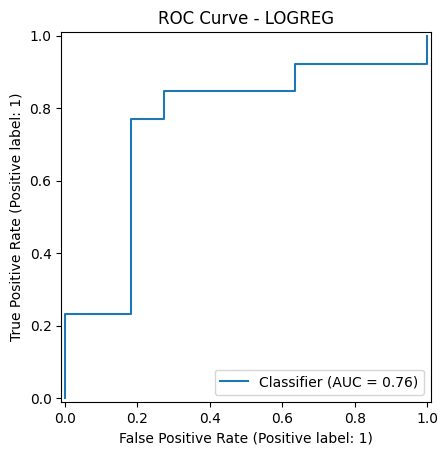


=== Avaliação do modelo: NB ===
Acurácia: 0.6666666666666666
Sensibilidade (Recall): 0.5384615384615384
Especificidade: 0.8181818181818182
ROC-AUC: 0.8181818181818182

Matriz de Confusão:
 [[9 2]
 [6 7]]


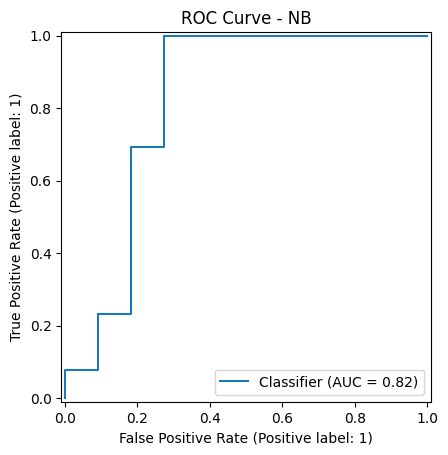


=== Avaliação do modelo: DT ===
Acurácia: 0.8333333333333334
Sensibilidade (Recall): 0.8461538461538461
Especificidade: 0.8181818181818182
ROC-AUC: 0.8286713286713286

Matriz de Confusão:
 [[ 9  2]
 [ 2 11]]


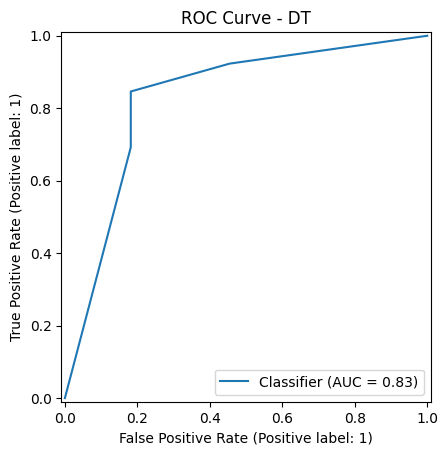


=== Avaliação do modelo: KNN ===
Acurácia: 0.9166666666666666
Sensibilidade (Recall): 0.9230769230769231
Especificidade: 0.9090909090909091
ROC-AUC: 0.8671328671328672

Matriz de Confusão:
 [[10  1]
 [ 1 12]]


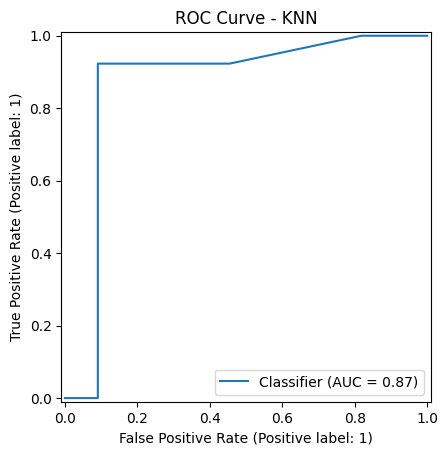


=== Avaliação do modelo: RF ===
Acurácia: 0.7916666666666666
Sensibilidade (Recall): 0.6923076923076923
Especificidade: 0.9090909090909091
ROC-AUC: 0.888111888111888

Matriz de Confusão:
 [[10  1]
 [ 4  9]]


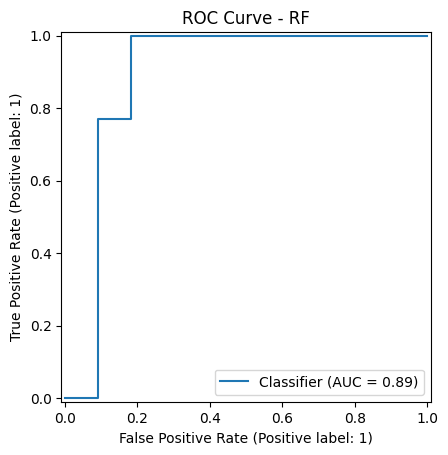

In [15]:
resultados_TT_features = []

for nome in modelos.keys():
    modelo_carregado = best_models_TT_features[nome]
    r = avaliar_modelo(modelo_carregado, nome, X_test_features, y_test)
    resultados_TT_features.append(r)

In [16]:
df_resultados_TT_features = pd.DataFrame(resultados_TT_features)
df_resultados_TT_features.to_csv("results/TT+features/resultados_TT_features.csv", index=False)

##### Aplicando em todas as colunas (sem seleção de features)

In [17]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
best_models_TT = {}

In [18]:
for nome, modelo in modelos.items():

    print(f"\n===== Rodando GridSearch com Treino/Teste e todas as features para: {nome} =====")

    # filtro de modelos que precisam de escalonamento
    if nome in ["logreg", "knn"]:
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("modelo", modelo)
        ])
    else:
        pipe = Pipeline([
            ("modelo", modelo)
        ])

    grid = GridSearchCV(
        estimator=pipe,
        param_grid=grades[nome],
        cv=cv,
        scoring="recall",
        n_jobs=-1
    )

    grid.fit(X_train, y_train)

    best_models_TT[nome] = grid.best_estimator_

    print("Melhores Parâmetros Treino/Teste para todas as features:", grid.best_params_)


===== Rodando GridSearch com Treino/Teste e todas as features para: logreg =====
Melhores Parâmetros Treino/Teste para todas as features: {'modelo__C': 0.01, 'modelo__max_iter': 1000, 'modelo__penalty': 'l2', 'modelo__solver': 'lbfgs'}

===== Rodando GridSearch com Treino/Teste e todas as features para: nb =====
Melhores Parâmetros Treino/Teste para todas as features: {}

===== Rodando GridSearch com Treino/Teste e todas as features para: dt =====
Melhores Parâmetros Treino/Teste para todas as features: {'modelo__criterion': 'gini', 'modelo__max_depth': 5, 'modelo__random_state': 10}

===== Rodando GridSearch com Treino/Teste e todas as features para: knn =====
Melhores Parâmetros Treino/Teste para todas as features: {'modelo__n_neighbors': 7, 'modelo__weights': 'uniform'}

===== Rodando GridSearch com Treino/Teste e todas as features para: rf =====
Melhores Parâmetros Treino/Teste para todas as features: {'modelo__bootstrap': True, 'modelo__max_depth': None, 'modelo__n_estimators': 2


=== Avaliação do modelo: LOGREG ===
Acurácia: 0.5
Sensibilidade (Recall): 0.9230769230769231
Especificidade: 0.0
ROC-AUC: 0.7692307692307694

Matriz de Confusão:
 [[ 0 11]
 [ 1 12]]


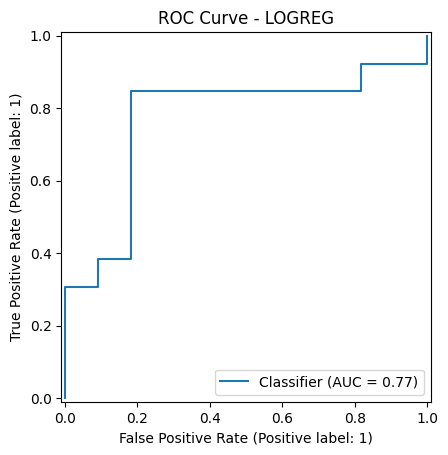


=== Avaliação do modelo: NB ===
Acurácia: 0.6666666666666666
Sensibilidade (Recall): 0.46153846153846156
Especificidade: 0.9090909090909091
ROC-AUC: 0.8671328671328671

Matriz de Confusão:
 [[10  1]
 [ 7  6]]


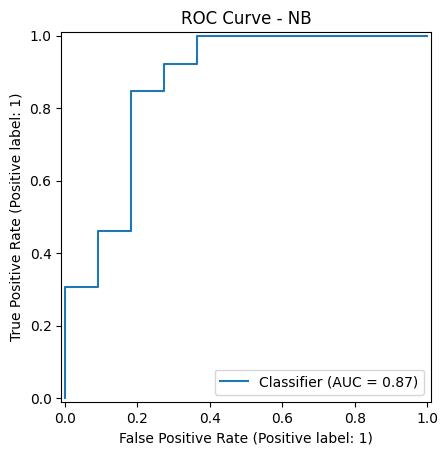


=== Avaliação do modelo: DT ===
Acurácia: 0.625
Sensibilidade (Recall): 0.5384615384615384
Especificidade: 0.7272727272727273
ROC-AUC: 0.6328671328671329

Matriz de Confusão:
 [[8 3]
 [6 7]]


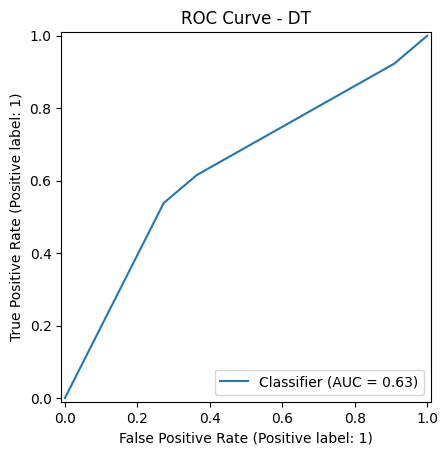


=== Avaliação do modelo: KNN ===
Acurácia: 0.75
Sensibilidade (Recall): 0.6923076923076923
Especificidade: 0.8181818181818182
ROC-AUC: 0.8146853146853147

Matriz de Confusão:
 [[9 2]
 [4 9]]


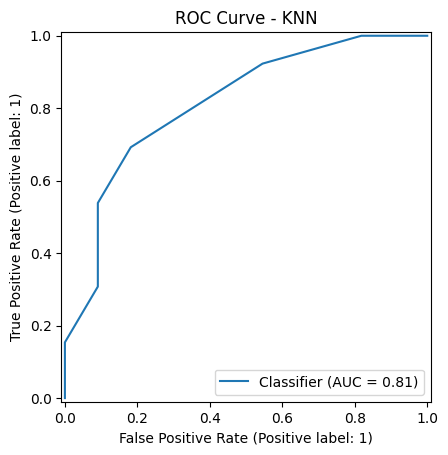


=== Avaliação do modelo: RF ===
Acurácia: 0.7916666666666666
Sensibilidade (Recall): 0.7692307692307693
Especificidade: 0.8181818181818182
ROC-AUC: 0.8671328671328672

Matriz de Confusão:
 [[ 9  2]
 [ 3 10]]


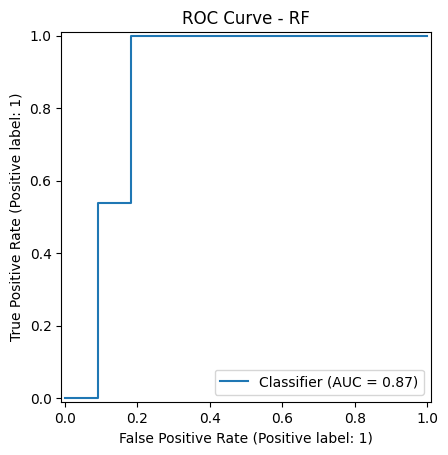

In [19]:
resultados_TT = []

for nome in modelos.keys():
    modelo_carregado = best_models_TT[nome]
    r = avaliar_modelo(modelo_carregado, nome, X_test, y_test)
    resultados_TT.append(r)

In [20]:
df_resultados_TT = pd.DataFrame(resultados_TT)
df_resultados_TT.to_csv("results/TT/resultados_TT.csv", index=False)